# 1. Data Processing
## 1.1 Data Download
We start downloading the `ethusdt` data from https://reach.stratosphere.capital/data/usdm/ and we save it in the `../data/usdm/` folderI

In [2]:
import datetime
from python.scripts.download_data import to_filename, download_file
from urllib.parse import urljoin

EXPORT_PATH = '../data/usdm/'
file_name = to_filename('ethusdt', datetime.date(2024, 7, 30))
dates = [datetime.date(2024, 7, 30), datetime.date(2024, 7, 31), datetime.date(2024, 8, 1)]
file_names = []
for date in dates:
    file_name = to_filename('ethusdt', date)
    url = urljoin('https://reach.stratosphere.capital/data/usdm/', file_name)
    dest = f'{EXPORT_PATH}{file_name}'
    print('Downloading...', url, 'to', dest)
    download_file(url, dest)
    file_names.append(dest)
print('Download Complete')


Downloading... https://reach.stratosphere.capital/data/usdm/ethusdt_20240730.gz to ../data/usdm/ethusdt_20240730.gz
Existing ../data/usdm/ethusdt_20240730.gz found, skipping download...
Downloading... https://reach.stratosphere.capital/data/usdm/ethusdt_20240731.gz to ../data/usdm/ethusdt_20240731.gz
Existing ../data/usdm/ethusdt_20240731.gz found, skipping download...
Downloading... https://reach.stratosphere.capital/data/usdm/ethusdt_20240801.gz to ../data/usdm/ethusdt_20240801.gz
Existing ../data/usdm/ethusdt_20240801.gz found, skipping download...
Download Complete


We visualize the first 10 lines of the data to understand the structure of the data. We find that the data has two data points per line, the first one is the timestamp from the data downloader in nanoseconds and the second one is the binance API data message in json format i.e (`b'<<timestam_ns>>' {<<binance message>>}`).


In [3]:
import gzip

with gzip.open(file_names[0], 'r') as f:
    for i in range(10):
        print(f.readline())

b'1722346072346098576 {"stream":"ethusdt@depth@0ms","data":{"e":"depthUpdate","E":1722346072148,"T":1722346072144,"s":"ETHUSDT","U":5048435410381,"u":5048435411907,"pu":5048435410345,"b":[["200.00","10.600"],["334.60","0.000"],["500.00","16.960"],["927.00","0.000"],["1003.80","0.037"],["3011.39","0.080"],["3342.65","3.901"],["3342.68","164.137"],["3342.83","0.088"],["3343.75","2.412"],["3344.91","0.297"],["3345.81","0.000"],["3345.91","1.243"]],"a":[["3346.43","11.954"],["3346.48","3.573"],["3346.52","6.717"],["3348.99","1.397"],["3349.04","2.330"],["3349.07","8.423"],["3349.12","2.750"],["3349.15","1.002"],["3349.18","1.438"],["3349.21","1.136"],["3349.27","3.455"],["3349.37","1.253"],["3349.47","19.270"],["3350.68","6.342"],["3352.19","1.830"],["3354.20","4.718"],["3361.56","12.851"],["3363.00","10.138"]]}}\n'
b'1722346072346295005 {"stream":"ethusdt@depth@0ms","data":{"e":"depthUpdate","E":1722346072201,"T":1722346072197,"s":"ETHUSDT","U":5048435412062,"u":5048435413544,"pu":5048435

## 1.2 Data Cleaning
Now that we have the data, we need to process it. We use `binancefutures.convert` function from hft-backtest which performs the following data normalization steps:
- Validates that the order of events is correct
- Adjusts the local timestamp in place if the feed latency is negative
- Corrects events that are out of order

In [13]:
from hftbacktest.data.utils import binancefutures
import polars as pl
import os
file_names = [
    '../data/usdm/ethusdt_20240808.gz'
]
for file_name in file_names:

    output_filename=file_name.replace('.gz','.npz')
    if os.path.exists(output_filename):
        print('File already exists :', output_filename)
        continue
    data = binancefutures.convert(file_name, 
                                  output_filename,
                                  combined_stream=True,
                                  buffer_size=1_000_000_000)

File already exists : ../data/usdm/ethusdt_20240730.npz
Correcting the latency
Correcting the event order
Saving to ../data/usdm/ethusdt_20240731.npz
Correcting the latency
Correcting the event order
Saving to ../data/usdm/ethusdt_20240801.npz


## 1.3 Data Analysis
We perform some basic data analysis to understand the data better. We load the data and visualize the first 10 lines of the data to understand the structure of the data. We find that the data has two data points per line, the first one is the timestamp from the data downloader in nanoseconds and the second one is the binance API data message in json format i.e (`b'<<timestam_ns>>' {<<binance message>>}`).

# 3. Latency Simulation 
In order to simulate order latency we will use feed latency data as a proxy (see `python.scripts.latency.latency.generate_order_latency` function). Even though this is not a perfect model, we will consider order latency as proportional to feed latency.


In [12]:
import os
from python.scripts.latency.latency import generate_order_latency
for file in file_names:
    from_file = file.replace('.gz','.npz')
    to_file = from_file.replace('.npz','_latency.npz').replace('../data/usdm/','../latency/')
    if not os.path.exists('../latency'):
        os.mkdir('../latency')
    if os.path.exists(to_file):
        print('File already exists :', to_file)
        continue
    print('Generating latency file:', to_file)
    order_latency = generate_order_latency(from_file, output_file=to_file, mul_entry=4, mul_resp=3)

    

Generating latency file: ../latency/ethusdt_20240730_latency.npz
Generating latency file: ../latency/ethusdt_20240731_latency.npz
Generating latency file: ../latency/ethusdt_20240801_latency.npz


In [11]:
from hftbacktest.data.utils.snapshot import create_last_snapshot
snapshot_data = create_last_snapshot(
    ['../data/usdm/ethusdt_20240730.npz'],
    tick_size=0.001,
    lot_size=0.001,
    output_snapshot_filename='../data/usdm/ethusdt_20240730_eod_snapshot.npz'
)
pl.DataFrame(snapshot_data)


ev,exch_ts,local_ts,px,qty,order_id,ival,fval
u64,i64,i64,f64,f64,u64,i64,f64
3758096388,0,0,3278.17,3.037,0,0,0.0
3758096388,0,0,3278.1,0.011,0,0,0.0
3758096388,0,0,3278.0,0.011,0,0,0.0
3758096388,0,0,3277.95,2.946,0,0,0.0
3758096388,0,0,3277.93,0.007,0,0,0.0
…,…,…,…,…,…,…,…
3489660932,0,0,8800.0,0.003,0,0,0.0
3489660932,0,0,10000.0,94.175,0,0,0.0
3489660932,0,0,32950.3,0.003,0,0,0.0


5. Backtesting 

We generate the data for backtesting the strategy (as a super simple model we set latency to be constant 

In [2]:
import numpy as np
from hftbacktest import BacktestAsset
#ethusdt_20240731 = np.load('../data/usdm/ethusdt_20240731.npz')['data']
ethusdt_20240730_eod = np.load('../data/usdm/ethusdt_20240730_eod_snapshot.npz')['data']


asset = (
    BacktestAsset()
        .data([
            '../data/usdm/ethusdt_20240731.npz'
        ])
        .initial_snapshot(ethusdt_20240730_eod)
        .linear_asset(1.0)
        .risk_adverse_queue_model()
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
)

### We generate bbo data statistics for the asset


In [ ]:
from numba import njit
from hftbacktest import HashMapMarketDepthBacktest
import polars as pl
from python.scripts.run_backtest import read_backtest_asset

asset = read_backtest_asset(0)
@njit
def plot_bbo(hbt, local_timestamp, best_bid, best_ask, best_bid_vol, best_ask_vol, spreads):
    while hbt.elapse(1 * 1e9) == 0:
        # Records data points
        local_timestamp.append(hbt.current_timestamp)
        depth = hbt.depth(0)
        spreads.append( int((depth.best_ask_tick - depth.best_bid_tick) / depth.best_bid_tick))
        best_ask_vol.append( depth.best_ask_tick*depth.ask_qty_at_tick(depth.best_ask_tick))
        best_bid_vol.append(depth.best_bid_tick*depth.bid_qty_at_tick(depth.best_bid_tick))
        best_bid.append(depth.best_bid)
        best_ask.append(depth.best_ask)
    return True

hbt = HashMapMarketDepthBacktest([asset])

from numba.typed import List
from numba import int64, float64
import matplotlib.pyplot as plt

local_timestamp = List.empty_list(int64, allocated=10000)
best_bid = List.empty_list(float64, allocated=10000)
best_ask = List.empty_list(float64, allocated=10000)
best_ask_vol = List.empty_list(float64, allocated=10000)
best_bid_vol = List.empty_list(float64, allocated=10000)
spreads = List.empty_list(float64, allocated=10000)
plot_bbo(hbt, local_timestamp, best_bid, best_ask, best_bid_vol, best_ask_vol, spreads)

hbt.close()

df = pl.DataFrame(
    {'timestamp': local_timestamp, 
     'best_bid': best_bid, 
     'best_ask': best_ask, 
     'best_bid_vol': best_bid_vol, 
     'best_ask_vol': best_ask_vol, 
     'spreads': spreads})
df = df.with_columns(
    pl.from_epoch('timestamp', time_unit='ns')
)



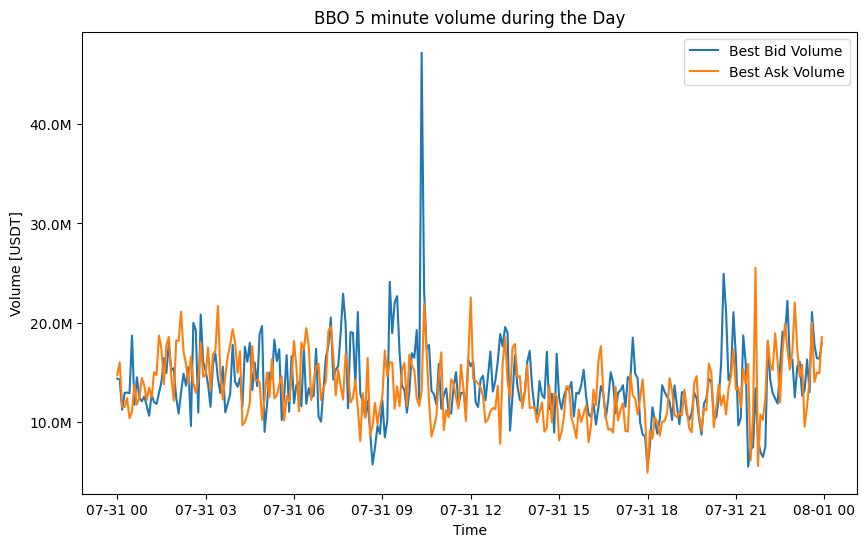

In [14]:
import pandas as pd
from matplotlib.ticker import FuncFormatter
df_pandas = df.to_pandas()

# Convert timestamp to datetime
df_pandas['timestamp'] = pd.to_datetime(df_pandas['timestamp'])

# Set timestamp as index
df_pandas.set_index('timestamp', inplace=True)

# Resample the data to hourly intervals and sum the volumes
hourly_volume = df_pandas.resample('5min').median()

# Plot the volume distribution
plt.figure(figsize=(10, 6))
plt.plot(hourly_volume.index, hourly_volume['best_bid_vol'], label='Best Bid Volume')
plt.plot(hourly_volume.index, hourly_volume['best_ask_vol'], label='Best Ask Volume')
plt.xlabel('Time')
plt.ylabel('Volume [USDT]')
plt.title('BBO 5 minute volume during the Day')
plt.legend()
# Apply the formatter to the y-axis
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [4]:
import numpy as np
from python.scripts.run_backtest import run_backtest
mkt_data_initial_snapshot = np.load('../data/usdm/ethusdt_20240730_eod_snapshot.npz')['data']
mkt_data_files=[
    '../data/usdm/ethusdt_20240731.npz',
]
latency_files=[
    '../latency/ethusdt_20240731_latency.npz',
]
#run_backtest(mkt_data_initial_snapshot, mkt_data_files, None, '../output/backtest_run_no_latency.npz')
run_backtest(mkt_data_initial_snapshot, mkt_data_files, latency_files, '../output/backtest_run_with_latency.npz')


Initializing backtest asset
Running backtest...
 [2024-07-30 21:00:01.019000] mkt_status: Buy mid_price: 3278.175, fair_price: 3295.2712324715744 bid_order_price: 3265.0, ask_order_price: 3325.0
 [2024-07-30 21:01:41.019000] mkt_status: Buy mid_price: 3277.455, fair_price: 3293.3785092266003 bid_order_price: 3263.0, ask_order_price: 3323.0
 [2024-07-30 21:03:21.019000] mkt_status: Buy mid_price: 3274.285, fair_price: 3292.301155803299 bid_order_price: 3262.0, ask_order_price: 3322.0
 [2024-07-30 21:05:01.019000] mkt_status: Buy mid_price: 3274.495, fair_price: 3291.320724779734 bid_order_price: 3261.0, ask_order_price: 3321.0
 [2024-07-30 21:06:41.019000] mkt_status: Buy mid_price: 3275.375, fair_price: 3292.1163534773113 bid_order_price: 3262.0, ask_order_price: 3322.0
 [2024-07-30 21:08:21.019000] mkt_status: Buy mid_price: 3272.855, fair_price: 3289.6824731847382 bid_order_price: 3260.0, ask_order_price: 3320.0
 [2024-07-30 21:10:01.019000] mkt_status: Buy mid_price: 3270.995, fair_

AttributeError: 'Recorder' object has no attribute 'stats'

### Now we generated the backtest data we can load it and analyze the results.



In [6]:
import numpy as np
from hftbacktest.stats import LinearAssetRecord
data = np.load('../output/backtest_run_with_latency.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats()
)
stats.summary()

#stats.plot()


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTradingValue,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-07-31 00:00:00,2024-07-31 23:55:00,18.953496,30.107315,52488.703037,21649.24125,9.031359,9.0283e6,2.424505,0.005834,2.0309e6
